# Sistema de Detecção de Fraudes em Transações

### Importar bibliotecas necessárias

In [1]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

from lightgbm import LGBMClassifier, Dataset
import lightgbm as lgb

# Otimização
import optuna

# Utilitários
import joblib
from datetime import datetime
import math

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abrir Base Transações

In [2]:
df_transacoes = pd.read_csv('./datasets/transacoes.csv')

### Visualizar primeiros e últimos registros

In [3]:
print('Primeiros registros:')
display(df_transacoes.head())

print('\nÚltimos registros:')
display(df_transacoes.tail())

Primeiros registros:


,ID_Transacao,ID_Cliente,Estabelecimento,Segmento,DataHora,Valor,Fraude
0,1ca88cf3-bd6d-438e-baff-861fa6c4a94e,a2db9269-561a-4e64-868d-cd167dd44ab1,Nogueira Pereira - ME,Loja Online,2024-11-09 21:06:16,332.66000,0
1,3d2481eb-c159-45c5-986e-fd524bf3a7be,3b830d7e-0054-4943-96ce-84b85e2cd1e4,Jesus,Oficina Mecânica,2023-06-22 05:26:52,17.01000,0
2,04151b5d-1d9c-49cd-8a09-2080bbcdeb1c,f737388d-52fc-47eb-8b44-8082beb8cc59,Dias S.A.,Posto de Combustível,2023-10-01 03:24:26,279.88000,1
3,ce10e2a4-59f1-49cf-adb1-abf6c01a08da,2fe8fdfa-d89f-46eb-8862-04a6b171fd43,Ribeiro,Oficina Mecânica,2024-06-30 22:17:53,124.92000,0
4,b02b67fc-f9fe-454d-85c9-ca75b18d062b,f6b635ff-4212-4948-af85-0c49379d4e93,Rezende,Posto de Combustível,2023-06-03 17:53:38,15.17000,0



Últimos registros:


,ID_Transacao,ID_Cliente,Estabelecimento,Segmento,DataHora,Valor,Fraude
9995,1a502af5-82ff-459f-8a41-3b10782cf03f,242f4e94-7f2a-4557-a27a-9227cca55e83,Pereira - EI,Pet Shop,2023-02-23 01:08:37,95.71000,0
9996,04380454-7767-49bb-ae14-4c7db1054c3a,93a4477e-914b-48e0-9e0e-02f873d870f1,da Cunha Andrade Ltda.,Eletrônicos,2024-02-28 06:33:53,1.83000,0
9997,aa7d0fbe-0530-4f86-990d-10af6309e55c,427c01e9-9c4f-46a1-870a-eeff546c5f3e,Camargo,Posto de Combustível,2023-06-12 10:26:29,8.62000,0
9998,7fa1bd91-63c2-4307-a47e-1b35a6022d86,3b1daffb-dbec-4c7b-91d5-0f05c02a054d,Nunes Ltda.,Teatro,2024-05-09 06:42:40,36.41000,0
9999,eca7e8ff-28a2-4d77-9528-70209e4f2648,2eff59e5-0d49-4687-9e09-00e18cd56f84,da Luz S.A.,Loja de Roupas,2024-02-19 17:57:42,43.52000,0


In [4]:
# Remover colunas únicas
df_transacoes.drop(columns=['ID_Cliente', 'ID_Transacao'], axis=1, inplace=True)

In [5]:
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Estabelecimento  10000 non-null  object 
 1   Segmento         10000 non-null  object 
 2   DataHora         10000 non-null  object 
 3   Valor            10000 non-null  float64
 4   Fraude           10000 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 390.8+ KB


### Feature Engineering

In [6]:
df_transacoes['DataHora'] = pd.to_datetime(df_transacoes['DataHora'])
df_transacoes['Hora'] = df_transacoes['DataHora'].dt.hour
df_transacoes['Dia_Semana'] = df_transacoes['DataHora'].dt.dayofweek
df_transacoes['Mes'] = df_transacoes['DataHora'].dt.month
df_transacoes = df_transacoes.drop('DataHora', axis=1)

### Cria lista de features e target

In [7]:
num_vars = df_transacoes.select_dtypes(include=['number']).columns
cat_vars = df_transacoes.select_dtypes(include=['object']).columns
target = 'Fraude'

### Estatísticas das variáveis numéricas

In [8]:
display(df_transacoes[num_vars].describe().T)

,count,mean,std,min,25%,50%,75%,max
Valor,10000.00000,110.04019,387.54919,0.18000,10.45000,25.62500,70.58750,11704.79000
Fraude,10000.00000,0.09440,0.29240,0.00000,0.00000,0.00000,0.00000,1.00000
Hora,10000.00000,10.92350,7.60233,0.00000,4.00000,10.00000,18.00000,23.00000
Dia_Semana,10000.00000,2.99630,2.00571,0.00000,1.00000,3.00000,5.00000,6.00000
Mes,10000.00000,6.52260,3.44007,1.00000,4.00000,7.00000,9.00000,12.00000


### Valores possíveis para variáveis categóricas

In [9]:
for var in cat_vars:
  print(f"\n{var}: {df_transacoes[var].nunique()} valores únicos")
  print(df_transacoes[var].value_counts().head())


Estabelecimento: 3156 valores únicos
Estabelecimento
Cavalcante    67
Sampaio       67
Fernandes     66
Pires         64
da Luz        62
Name: count, dtype: int64

Segmento: 25 valores únicos
Segmento
Loja Online             434
Livraria                433
Posto de Combustível    424
Farmácia                424
Eletrônicos             420
Name: count, dtype: int64


### Apresentar histograma das variáveis numéricas

In [10]:
# Número de colunas desejadas
num_cols = 2

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(num_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(num_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1
  fig.add_trace(
    go.Histogram(x=df_transacoes[var], name=var, ),
    row=row, col=col
  )

# Atualizar layout
fig.update_layout(
  height=300 * num_rows,
  width=1200,
  title_text="Histogramas das Variáveis Numéricas",
  showlegend=False,
)
fig.show()

### Gráfico de barras para variáveis categóricas

In [12]:
# Número de colunas desejadas
num_cols = 2

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(cat_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar gráficos de barras para cada variável categórica
for i, var in enumerate(cat_vars):
  row = (i // num_cols) + 1
  col = (i % num_cols) + 1
  fig.add_trace(
    go.Bar(
      x=df_transacoes[var].value_counts().index[:10], 
      y=df_transacoes[var].value_counts().values[:10], 
      name=var
    ),
    row=row, col=col
  )

# Atualizar layout
fig.update_layout(
  height=500 * num_rows,
  width=1200,
  title_text="Gráficos de Barras das Variáveis Categóricas",
  showlegend=False,
)
fig.show()

### Boxplot e histograma entre features e target

In [13]:
# Analisando relação entre variáveis explicativas e targets
for col in num_vars:
  fig = px.box(df_transacoes, x=target, y=col, title=f"{col} por {target}")
  fig.show()

for col in cat_vars:
  fig = px.histogram(df_transacoes, x=col, color=target, barmode='group', title=f"{col} por {target}")
  fig.show()

### Matriz de correlação

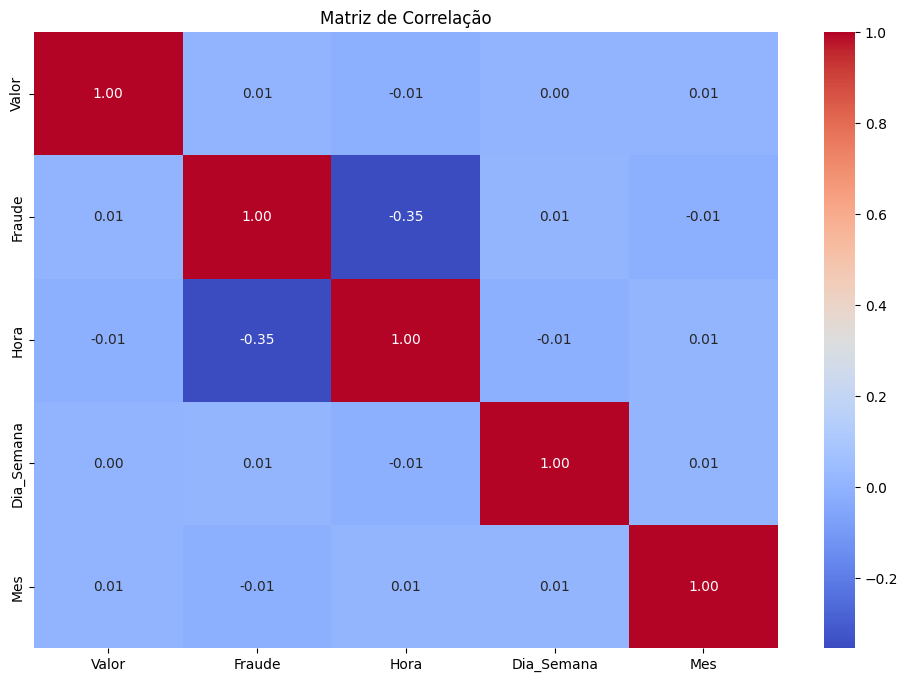

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_transacoes[num_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

### Testes de Hipóteses

In [15]:
# Testes de hipóteses entre Target Categórica e Númericas (ANOVA)
for num_col in num_vars:
  groups = [df_transacoes[df_transacoes[target] == var][num_col] for var in df_transacoes[target].unique()]
  stat, p = f_oneway(*groups)
  print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
        f"ANOVA entre {num_col} e {target}: p-valor = {p}")

ANOVA entre Valor e Fraude: p-valor = 0.5304523147441481
ANOVA entre Fraude e Fraude: p-valor = 0.0
ANOVA entre Hora e Fraude: p-valor = 2.335008397558635e-291
ANOVA entre Dia_Semana e Fraude: p-valor = 0.3799386946687383
ANOVA entre Mes e Fraude: p-valor = 0.17847355723925032


/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning:

Each of the input arrays is constant; the F statistic is not defined or infinite

